<a href="https://colab.research.google.com/github/nguyenha1910/YouTubeCommentAnalysis/blob/main/assignment3_nh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions

Work through the assignment 2 notebook, and use this notebook to provide your answers. Be aware that the code cell for `customDataset` in this template is with complete instruction. 

To submit the assignment, you will need to use GitHub and the existing private repository you already created called `adleoxyz` (xyz is your initials)

Once you have completed the assignment:
- Commit your notebook from colab to your private GitHub repo
- The notebook should be named assignment3_xyz.ipynb, with xyz again replaced by your initials.
- There are 50 points in this assignment, with an additional 8 extra credit. 

# Answers to the theoretical questions 
Please provide your answers to questions 1-3 here.

(20 points total)



**Answer to Q1**   

a) 
- The input shape: ($1.8^{13}$).
  - 10000x15000x8000x15 = $1.8^{13}$
- The shape of the weight matrix for the hidden layer: ($1.8^{13}$, number of hidden units)
- The shape of the bias vector for the hidden layer: (number of hidden units,)
- The shape of the weight matrix for the output layer: (number of hidden units, $7.2^{12}$s)
  - 10000x15000x8000x6 = $7.2^{12}$
- The shape of bias vector for the output layer: ($7.2^{12}$,)
- According to this [source](https://www.heatonresearch.com/2017/06/01/hidden-layers.html), a good choice for the number of hidden units should be 2/3 of input size + output size
```
2/3*1.8e+13 + 7.2e+12 = 1.92e+13
```
- Wow this design is bad 😞.

b) 
- The LeNet model in assignment 2 only downsamples and returns results for  a number of classes (in this case, it's 15). To use LeNet, we would have to add to it so that it can upsample and dense classfication. For example, we can add a decoder. 
- Input shape: (batch size, 15000x8000, 15)


**Answer to Q2**
1. Less parameters: Convolution layers share their weights across each band of an image. 
2. Translation invariance: Convolution layers are able to detect features at different spatial locations in the input image. This is necessary for image classification tasks, since an object can appear in different locationa of the image.
3. Spatial information in a neighborhood: Convolution layers learn spatial information in a neighborhood, so the model can learn complex features with multiple convolution layers stacked together.

**Answer to Q3**
- The lesson learned from the design of decoder in FCN is that skip connections between the encoder and decoder can improve the accuracy of semantic segmentation.
- This is because skip connections bring spatial information from lower levels (from the encoder) to the decoder (i.e. FCN-8). 
- Simplying doing upsampling does not do as well because the encoder's result resolution is not high (i.e. FCN-32).




---


# **Practical starts from Here**

---





In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
%%capture
!pip install rasterio

In [ ]:
import numpy as np
import os
import pandas as pd
import numpy.ma as ma
import rasterio
import cv2
import random
import math
import numbers
from pathlib import Path
from scipy.ndimage import rotate
from scipy.ndimage import shift

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from IPython.core.debugger import set_trace

## Coding Assignment 1 

10 points total

In all code cells below change "your_model_name" with the name you choose for your model. My recommendation: "unet" + "_" + "your initial".

In [ ]:
class ConvBlock(nn.Module):
    """(convolution => BN => ReLU => Dropout) * n"""

    def __init__(self, in_channels, out_channels, num_layers=2, dropout_rate=0):
        super().__init__()
        layers = []
        for i in range(num_layers):
          if i==0:
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
          else:
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
          layers.append(nn.BatchNorm2d(out_channels))
          layers.append(nn.ReLU(inplace=True))
          in_channels = out_channels
        if dropout_rate > 0:
          layers.append(nn.Dropout2d(p=dropout_rate))
        self.conv_block = nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv_block(x)
        return x

In [ ]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers=2, dropout_rate=0):
        super(Down, self).__init__()
        self.conv = ConvBlock(in_channels, out_channels, num_layers=num_layers, dropout_rate=dropout_rate)
        self.pool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        x = self.conv(x)
        skip = x
        x = self.pool(x)
        return x, skip
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, num_layers=1, dropout_rate=dropout_rate)
        
    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

In [309]:
class unet(nn.Module):
    def __init__(self, n_classes, in_channels, 
                 filter_config=(64, 128, 256, 512, 1024), dropout_rate=0):
        """
          Pytorch implementation of UNet with VGG16 backbone.

          Args:
              n_classes (int) : Number of categories in the semantic segmentation 
                  task.
              in_channels (int) : Number of bands in your input image chips.
              filter config : A list with integer elements that shows the number 
                  of output feature maps in each conv layer.
              dropout_rate (float) : probability to apply drop out.

          Returns:
              Initialized pytorch.model object.
        """
        super(unet, self).__init__()
        # downsample
        self.down1 = Down(in_channels, filter_config[0], num_layers=2, dropout_rate=dropout_rate)
        self.down2 = Down(filter_config[0], filter_config[1], num_layers=2, dropout_rate=dropout_rate)
        self.down3 = Down(filter_config[1], filter_config[2], num_layers=2, dropout_rate=dropout_rate)
        self.down4 = Down(filter_config[2], filter_config[3], num_layers=3, dropout_rate=dropout_rate)
        self.down5 = Down(filter_config[3], filter_config[4], num_layers=3, dropout_rate=dropout_rate)

         # bottleneck layers
        self.bottleneck = ConvBlock(filter_config[4], filter_config[4], num_layers=2, dropout_rate=dropout_rate)
        
        # upsample
        self.up1 = Up(filter_config[4], filter_config[3])
        self.up2 = Up(filter_config[3], filter_config[2])
        self.up3 = Up(filter_config[2], filter_config[1])
        self.up4 = Up(filter_config[1], filter_config[0])

        self.dimTrans = nn.Conv2d(filter_config[0], n_classes, kernel_size=1)

    def forward(self, x):
        # downsample
        x_down1, x = self.down1(x)
        x_down2, x = self.down2(x)
        x_down3, x = self.down3(x)
        x_down4, x = self.down4(x)
        x_down5, x = self.down5(x)

        # upsample
        x = self.up1(x_down5, x_down4)
        x = self.up2(x, x_down3)
        x = self.up3(x, x_down2)
        x = self.up4(x, x_down1)

        output_logits = self.dimTrans(x)
        return output_logits

### Show your work

To test if you got it right lets initialize our model and print it.

In [ ]:
n_classes = 2
in_channels = 6
filter_config = (64, 128, 256, 512, 1024) 
dropout_rate = 0.15

In [310]:
model = unet(n_classes, in_channels, filter_config, dropout_rate)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 58,590,594 trainable parameters


In [311]:
print(model)

unet(
  (down1): Down(
    (conv): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): Dropout2d(p=0.15, inplace=False)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): Down(
    (conv): ConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

## Coding assignment 2 

20 points total

### Static code

In [ ]:
#@title Input normalization
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) -- Absolute path to the image patch.
    dtype (numpy datatype) -- data type of the normalized image default is "np.float32".
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)
    # normalized_img = normalized_img.astype(dtype)

    # Return the normalized image data
    return normalized_img

#### Image augmentation 
Two functions for augmentation are included in the static code here. You can choose from these, or include others from the main assignment instead (e.g. translation, blur, gamma). If you do choose to add others, please add the functions into the chunks where indicated below in Coding Task section below. 

In [ ]:
#@title Rotation transformation (`cv2`)

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle 
            (in degrees) respectively. If number of elements are bigger than 2, 
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], 
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], 
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

In [ ]:
#@title Image flipping (`cv2`)
def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either 
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = cv2.flip(image, 1)
        
        # Apply horizontal flip augmentation to the label
        flipped_label = cv2.flip(label, 1)
        
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = cv2.flip(image, 0)
        
        # Apply vertical flip augmentation to the label
        flipped_label = cv2.flip(label, 0)
        
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
        
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()

#### Chipping

In [ ]:
#@title Get the center index for chipping
def patch_center_index(cropping_ref, patch_size, overlap, usage, 
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate 
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for 
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of 
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of 
        patches to extract from the input
    """

    assert usage in ["train", "val"]

    mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer 
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer 
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of 
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of 
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size, 
                            j - half_size: j + half_size]
            label_ref = label[i - half_size: i + half_size, 
                              j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "val") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without 
    # considering the class proportions.
    if usage == "val":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

#### Helper functions

Code for plotting images.  You will use these to demonstrate your work. 

In [ ]:
#@title Plot RGB composite or single band image

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image(image_array, cmap="grey", band_composite=None, stretch=None):
    r"""
    Plots a loaded image using matplotlib and rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        stretch (str) : A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        cmap (str) : A string specifying the color map to use for the image 
            (default:'gray').
        band_composite (tuple of int) : A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

    if ((image_array.ndim == 3) and 
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)

    image_size=[image_array.shape[0], image_array.shape[1]]

    # If a band composite is specified, create an RGB image
    if band_composite:
        # Get the individual bands
        red_band = image_array[:, :, band_composite[0] - 1]
        green_band = image_array[:, :, band_composite[1] - 1]
        blue_band = image_array[:, :, band_composite[2] - 1]

        # Stack the bands to create an RGB image
        rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

        # Apply the contrast stretch if specified
        if stretch:
            p_min, p_max = np.percentile(rgb_image, (2, 98))
            stretched = exposure.rescale_intensity(
                rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = rgb_image

        # Display the RGB image using matplotlib
        ax.imshow(stretched)
    
    # Otherwise, display the single-band image
    else:
        if stretch:
            p_min, p_max = np.percentile(image_array, (2, 98))
            stretched = exposure.rescale_intensity(
                image_array, in_range=(p_min, p_max), out_range=(0, 1)
            )
        else:
            stretched = image_array
        
        # Display the image using rasterio.plot.show
        rp.show(stretched, ax=ax, cmap=cmap)


    # Add a title and axis labels
    ax.set_title('Image')
    ax.set_xlabel(f'# Column: {image_size[0]}')
    ax.set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    plt.show()

In [ ]:
#@title Plot RGB composite and label pair

import rasterio.plot as rp
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure

def plot_image_and_label(image_array, label_array, band_composite=None, 
                         stretch=None):
    r"""
    Plots a loaded image and its corresponding label using matplotlib and 
    rasterio.plot.

    Args:
        image_array (numpy.ndarray) : A numpy array containing image data.
        label_array (numpy.ndarray) : A numpy array containing label data.
        stretch (str) : A string specifying the contrast stretch to apply to the 
            image (e.g. 'linear', 'sqrt', or 'log').
        band_composite (tuple of int) : A tuple specifying the band indices to 
            use for an RGB image (e.g. (3, 2, 1)).

    Returns:
        None
    """
    # Set up the figure and axes
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

    if ((image_array.ndim == 3) and 
        (image_array.shape[0] == np.min(image_array.shape))):
        image_array = image_array.transpose(1,2,0)
    
    image_size=[image_array.shape[0], image_array.shape[1]]
    label_size=[label_array.shape[0], label_array.shape[1]]

    # If a band composite is specified, create an RGB image
    red_band = image_array[:, :, band_composite[0] - 1]
    green_band = image_array[:, :, band_composite[1] - 1]
    blue_band = image_array[:, :, band_composite[2] - 1]

    # Stack the bands to create an RGB image
    rgb_image = np.stack([red_band, green_band, blue_band], axis=-1)

    # Apply the contrast stretch if specified
    if stretch:
        p_min, p_max = np.percentile(rgb_image, (2, 98))
        stretched = exposure.rescale_intensity(
            rgb_image, in_range=(p_min, p_max), out_range=(0, 1)
        )
    else:
        stretched = rgb_image

    # Display the RGB image using matplotlib
    axs[0].imshow(stretched)
    
    # Add a title and axis labels
    axs[0].set_title('Image')
    axs[0].set_xlabel(f'# Column: {image_size[0]}')
    axs[0].set_ylabel(f'# Row: {image_size[1]}')

    # Show the plot
    axs[0].axis('off')

    # Plot label chip
    axs[1].imshow(label_array, cmap='viridis')
    axs[1].set_title('Label')
    axs[1].set_xlabel(f'# Column: {label_size[0]}')
    axs[1].set_ylabel(f'# Row: {label_size[1]}')

    # Show the plot
    axs[1].axis('off')
    plt.show()

In [ ]:
#@title Plot random patches from the Pytorch customDataset object.

import numbers
import matplotlib.pyplot as plt

def show_random_patches(dataset, sample_num, rgb_bands=(4, 5, 3)):
    """
    Plots a user-defined number of image chips and the corresponding labels.
    Arguments:
    dataset (AquacultureData object) : Loaded custom dataset.
    sample_num (int) : Number of pairs of image chips and their corresponding 
        labels to be plotted.
    rgb_bands (tuple of int) : List of the rgb bands for visualization indexed 
        from zero.
    Note: The order of the input bands is as follows:
          bands = {0 : "Landsat band 2 (Blue)",
                   1 : "Landsat band 3 (Green)",
                   2 : "Landsat band 4 (Red)",
                   3 : "Landsat band 5 (NIR)",
                   4 : "Landsat band 6 (SWIR 1)",
                   5 : "Landsat band 7 (SWIR 2)"}
    """
    # Because train_dataset does dynamic augmentation, we first make a deep copy 
    # of it before ploting.
    static_dataset = list(dataset)

    if ((isinstance(rgb_bands, tuple) or isinstance(rgb_bands, list)) and
            (len(rgb_bands) == 3) and
            (isinstance(rgb_bands[0], numbers.Number) and
             isinstance(rgb_bands[1], numbers.Number) and
             isinstance(rgb_bands[2], numbers.Number)) and
            ((sample_num is not None) and 
             (1 <= sample_num <= len(static_dataset)))):
        r = rgb_bands[0]
        g = rgb_bands[1]
        b = rgb_bands[2]

        nrow = sample_num
    else:
        del static_dataset
        raise ValueError("'sample_num' or 'rgb_bands' are not properly defined")

    # Randomly select as many patches as the user defined for plotting.
    sample_index = []
    ncol = 2

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(16, nrow * 16 / 2), 
                            squeeze=False)

    for index in range(sample_num):
        sample_index.append(random.randrange(len(static_dataset)))

    viewSize = static_dataset[sample_index[0]][1].shape

    for i in range(sample_num):
        b_r = static_dataset[sample_index[i]][0][r,:,:].cpu().view(1, *viewSize)
        b_g = static_dataset[sample_index[i]][0][g,:,:].cpu().view(1, *viewSize)
        b_b = static_dataset[sample_index[i]][0][b,:,:].cpu().view(1, *viewSize)

        if (b_r.max() - b_r.min()) > 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0).int()

        elif 0 <= (b_r.max() - b_r.min()) <= 1:
            rgb = torch.cat([b_r, b_g, b_b], 0).permute(1, 2, 0)

        axs[i, 0].set_title('Image Patch #{}'.format(sample_index[i]))
        axs[i, 0].imshow(rgb)
        axs[i, 1].set_title('Label Patch #{}'.format(sample_index[i]))
        axs[i, 1].imshow(static_dataset[sample_index[i]][1])

    plt.show()
    del static_dataset

### Coding Tasks

Modify the code below here to complete the second coding assignment. 

#### Load the dataset
Let's first make ourselves familiar with our dataset, using `rasterio`. 

Note that we're not passing any arguments to `src.read()` since we want to read all bands of the image. If you want to read a specific band, you can pass the band number as an argument (e.g. `src.read(3)` to read the third band).

First we load the imagery. The image source is kept in a csv catalog that will provides the file name and path for the label image, the mask image, and the Landsat image. There are set of these for each training and validation. Let's have a look. 

In [ ]:
# Define the path to the catalog in Google Drive (shared with you). 
# Modify it as needed to match your Drive structure. 
# you may find it helpful to define a variable that contains the path root 
# (src_dir)
src_dir = "/content/gdrive/MyDrive/sam/GEOG315/assignment3_data/"
csv_name = "pond_scenes_train_val.csv"
catalog = pd.read_csv(os.path.join(src_dir, csv_name))
catalog

,country,region,wrs_path,wrs_row,year,usage,img_dir,label_dir,mask_dir
0,indonesia,indramayu,121,64,2014,train,clip_tile_121_64/bands/comp456_2014_clip_121_6...,clip_tile_121_64/label/ponds_2014_clip_121_64.rst,clip_tile_121_64/mask/mask_2014_clip_121_64.rst
1,indonesia,jakarta,122,64,2014,validate,clip_tile_122_64/bands/comp456_2014_clip_122_6...,clip_tile_122_64/label/ponds_2014_clip_122_64.rst,clip_tile_122_64/mask/mask_2014_clip_122_64.rst


Now let's use those directory paths in the csv to read in and display the imagery, label, and mask for the training path. 

In [204]:
# Define the path to the image file in Google Drive
img_path = os.path.join(src_dir, catalog[catalog.usage=='validate']['img_dir'].iloc[0])

# Open the image with rasterio
with rasterio.open(img_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    image = src.read()
    image = image.transpose(1,2,0)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 6244, 'height': 6367, 'count': 3, 'crs': CRS.from_epsg(32648), 'transform': Affine(15.0, 0.0, 714667.5,
       0.0, -15.0, -626722.5), 'blockysize': 1, 'tiled': False}


Let's get the labels

In [205]:
# Define the path to the label file in Google Drive
lbl_path = os.path.join(src_dir, 
                        catalog[catalog.usage=='validate']['label_dir'].iloc[0])

with rasterio.open(lbl_path) as src:
    # Print some metadata about the image
    print(src.profile)
    # Access the image data as a numpy array
    label = src.read(1)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 6244, 'height': 6367, 'count': 1, 'crs': CRS.from_epsg(32648), 'transform': Affine(15.0, 0.0, 714667.5,
       0.0, -15.0, -626722.5), 'blockysize': 1, 'tiled': False}


Let's visualize the image and labels. Note that you can change the order of the 3 bands for different renderings. 

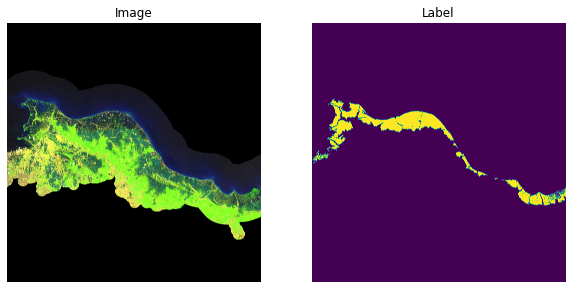

In [206]:
band_composite=(2,1,0)
stretch = True

plot_image_and_label(image, label, band_composite, stretch)

Last, we will look at the mask image. 

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 6244, 'height': 6367, 'count': 1, 'crs': CRS.from_epsg(32648), 'transform': Affine(15.0, 0.0, 714667.5,
       0.0, -15.0, -626722.5), 'blockysize': 1, 'tiled': False}


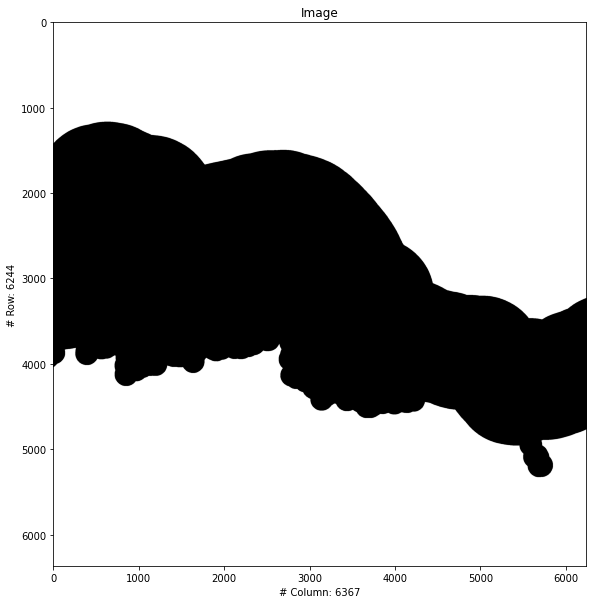

In [207]:
msk_path = os.path.join(src_dir, catalog[catalog.usage=='validate']['mask_dir'].iloc[0])

with rasterio.open(msk_path) as src:
    print(src.profile)
    mask = src.read(1)

plot_image(mask, "Greys")

So that's the imagery.  Now we will to move on to examining augmentations. 

#### Test the image processing/augmentation functions

You will want to see--and demonstrate--how the augmentations work, and we will want to see them outside of the data loader that you will be making below.  So, let's run them first.  

##### Normalization

You will need to start by applying image normalization. Run your normalization code here. If you developed one that can clip the tails of the distribution, use that here, and it will be worth an extra 3 points. 

You might want to write a function that simultaneously loads the image and applies the normalization at the same time. You might even want to make it so that the function can differentiate between images and labels. For the images, note that you will have to be careful might have to be careful to run the transpose after normalizing.  
 

###### Optional coding assignment 1 

(3 points)

Modify the min-max input normalization (`min_max_normalize_image`) to clip the tail distributions based on a "clip_threshold" argument. For instance, trim of the 1st and 99th percentile values in each image.  (3 points)

To do this, modify the `min_max_normalize_image` function cell below, renaming it `min_max_normalize_image_wclip`. Run it instead of `min_max_normalize_image` when normalizing your image (we recommend applying a 1% clip to either tail), both here and in the custom loader.



In [ ]:
## Modify the normalization function here. Otherwise leave as is.
def min_max_normalize_image(image, dtype=np.float32):
    """
    image_path(str) : Absolute path to the image patch.
    dtype (numpy datatype) : data type of the normalized image default is "np.float32".
    """

    image = np.nan_to_num(image)
    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)

    # Return the normalized image data
    return normalized_img


def min_max_normalize_image_wclip(image, dtype=np.float32, clip_threshold=0):
    """
    image (numpy array): image to be normalized.
    dtype (numpy datatype) : data type of the normalized image, default is "np.float32".
    clip_percentile (float) : percentile to clip from the tails of the distribution, default is 0 (no clipping).
    """

    # Calculate the minimum and maximum values for each band
    min_values = np.nanmin(image, axis=(1, 2))[:, np.newaxis, np.newaxis]
    max_values = np.nanmax(image, axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Clip the tails of the distribution if requested
    if clip_threshold > 0:
        clip_min = np.percentile(image, clip_threshold, axis=(1, 2))[:, np.newaxis, np.newaxis]
        clip_max = np.percentile(image, 100-clip_threshold, axis=(1, 2))[:, np.newaxis, np.newaxis]
        image = np.clip(image, clip_min, clip_max)

    # Normalize the image data to the range [0, 1]
    normalized_img = (image - min_values) / (max_values - min_values)

    # Return the normalized image data
    return normalized_img.astype(dtype)

###### Load image and apply normalization 

(1 point, with 3 extra if tail-clip normalization is completed)

In [209]:
# Write your code for applying normalization here. 
# Probably easiest to read in the image again, normalize, and then transpose 

img_path = os.path.join(src_dir, catalog[catalog.usage=='train']['img_dir'][0])
with rasterio.open(img_path) as src:
    image_array = src.read()
    normalized_image = min_max_normalize_image_wclip(image_array, clip_threshold=1)
    normalized_image = image_array.transpose(1, 2, 0)

###### Plot the normalized image
Show your result here by running the plotting code

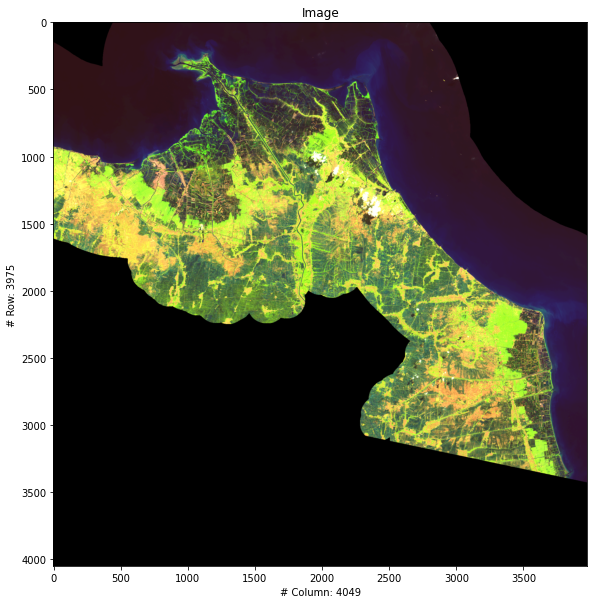

In [210]:
plot_image(normalized_image, band_composite=band_composite, stretch=stretch)

##### Get a chip for testing

(2 points, with 5 extra if optional assignment is completed)

We want to now look at the different augmentations, outside of the data loader.  

This will require running the function for getting the center index, and then converting to chips. You can then extract a chip to test different augmentation functions. 

You need a few ingredients here: 

- Arguments:
    - patch_size = 256
    - overlap = 32 
    - positive_class_threshold = 0.2
    - crop_ref = [mask, label] 
- You will also need to divide patch_size in half correctly reference from cell center x, y to get the bounds of each chip. 
- A list `coor` will be needed to catch the indices for x, y, which is the output from `patch_center_index`. 
- A list to catch the image chips, and one to catch the label chips. 
- To get an image chip you need to do something like this:

  ```python
  img_chips = []  # list to catch the chips
  half_win = patch_size // 2  # 1/2 patch size
  # subset image--note the extra dimension for the channel
  img_chips.append(img[x-half_win:x+half_win,   
                       y-half_win:y+half_win, :])
  ```

###### Optional coding assignment 2 

(5 points)

Can you modify the chipping code to get the index of the upper left corner of each small chip, instead of getting the center point? If you decide to make the change make sure you also make appropriate changes when you are using those indices in the actual chipping process. (5 points)

If you are going to do this, modify the function for getting the center index (call it `get_upperleft_index`) in the cell below. Run it instead of `get_center_index` when making your chips, both here and in the custom loader. Note that the advice above for making the chips will differ a bit also. 

In [195]:
### Add your indexing function here.  Otherwise leave as is.
# def get_upperleft_index(...):

#@title Snippet code to get the index of center of each smaller chip

def patch_center_index(cropping_ref, patch_size, overlap, usage, 
                       positive_class_threshold=None, verbose=True):
    r"""
    Generate index to divide the scene into small chips.
    Each index marks the location of corresponding chip center.
    Arguments:
        cropping_ref (list) : Reference raster layers, to be used to generate 
            the index. In our case, it is study area binary mask and label mask.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : amount of overlap between the extracted chips.
        usage (str) : Either 'train', 'val'. Chipping strategy is different for 
            different usage.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
    verbose (binary) : If set to True prints on screen the detailed list of 
            center coordinates of the sampled chips.
    Returns:
        proportional_patch_index : A list of index recording the center of 
        patches to extract from the input
    """

    assert usage in ["train", "validate"]

    mask, label = cropping_ref

    half_size = patch_size // 2
    step_size = patch_size - 2 * overlap

    proportional_patch_index = []
    non_proportional_patch_index = []
    neg_patch_index = []

    # Get the index of all the non-zero elements in the mask.
    x = np.argwhere(mask)

    # First col of x shows the row indices (height) of the mask layer 
    # (iterate over the y axis or latitude).
    x_min = min(x[:, 0]) + half_size
    x_max = max(x[:, 0]) - half_size
    # Second col of x shows the column indices (width) of the mask layer 
    # (iterate over the x axis or longitude).
    y_min = min(x[:, 1]) + half_size
    y_max = max(x[:, 1]) - half_size

    # Generate index for the center of each patch considering the proportion of 
    # each category falling into each patch.
    for j in range(y_min, y_max + 1, step_size):

        for i in range(x_min, x_max + 1, step_size):

            # Split the mask and label layers into patches based on the index of 
            # the center of the patch
            mask_ref = mask[i - half_size: i + half_size, 
                            j - half_size: j + half_size]
            label_ref = label[i - half_size: i + half_size, 
                              j - half_size: j + half_size]

            if (usage == "train") and mask_ref.all():

                if label_ref.any() != 0:
                    pond_ratio = np.sum(label_ref == 1) / label_ref.size
                    if pond_ratio >= positive_class_threshold:
                        proportional_patch_index.append([i, j])
                else:
                    neg_patch_index.append([i, j])

            if (usage == "validate") and (label_ref.any() != 0) and mask_ref.all():
                non_proportional_patch_index.append([i, j])

    if usage == "train":

        num_negative_samples = min(
            math.ceil(0.2 * len(proportional_patch_index)), 15
        )
        neg_samples = random.sample(neg_patch_index, num_negative_samples)

        proportional_patch_index.extend(neg_samples)

    # For test set use the indices generated from mask without 
    # considering the class proportions.
    if usage == "validate":
        proportional_patch_index = non_proportional_patch_index

    if verbose:
        print("Number of patches:", len(proportional_patch_index))
        print("Patched from:\n{}".format(proportional_patch_index))

    return proportional_patch_index

###### Apply chipping 

In [86]:
patch_size = 256
overlap = 32
positive_class_threshold = 0.2
crop_ref = [mask, label]

In [211]:
# index = #call the chipping function with proper arguments

# Call the patch_center_index() function to get the patch indices
coor = patch_center_index([mask, label], patch_size, overlap, "validate", positive_class_threshold)

Number of patches: 123
Patched from:
[[3021, 128], [3213, 128], [3405, 128], [1869, 320], [2061, 320], [2445, 320], [2637, 320], [2829, 320], [3021, 320], [3213, 320], [3405, 320], [1869, 512], [2061, 512], [2253, 512], [2445, 512], [2637, 512], [2829, 512], [3021, 512], [3213, 512], [3405, 512], [1869, 704], [2061, 704], [2253, 704], [2445, 704], [2637, 704], [2829, 704], [3021, 704], [3213, 704], [1869, 896], [2061, 896], [2253, 896], [2445, 896], [2637, 896], [2829, 896], [3021, 896], [1869, 1088], [2061, 1088], [2253, 1088], [2445, 1088], [2637, 1088], [2061, 1280], [2253, 1280], [2445, 1280], [2253, 1472], [2445, 1472], [2637, 1472], [2253, 1664], [2445, 1664], [2637, 1664], [2253, 1856], [2445, 1856], [2637, 1856], [2253, 2048], [2445, 2048], [2637, 2048], [2253, 2240], [2445, 2240], [2637, 2240], [2061, 2432], [2253, 2432], [2445, 2432], [2637, 2432], [2061, 2624], [2253, 2624], [2445, 2624], [2637, 2624], [2061, 2816], [2253, 2816], [2445, 2816], [2637, 2816], [2253, 3008], [24

In [212]:
img_chips = []  # list to catch the chips
lbl_chips = []
half_win = patch_size // 2  # 1/2 patch size
# subset image--note the extra dimension for the channel
for x, y in coor:
  img_chips.append(image[x-half_win:x+half_win,   
                      y-half_win:y+half_win, :])
  lbl_chips.append(label[x-half_win:x+half_win,   
                      y-half_win:y+half_win])

###### Plot your selected chip

Select a single chip by index and then plot it--both the image and label chip.

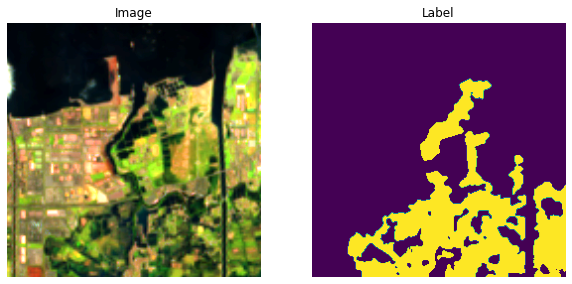

In [226]:
plot_image_and_label(img_chips[1], lbl_chips[1], band_composite, stretch)

##### Augmentation 1

(1 point)

Run your first chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that. 

###### Augmentation function (optional) 

In [132]:
### Add your first augmentation function here, if using a different function 
# then those provided here. Otherwise, leave this as is
#@title Rotation transformation using "cv2" library.

import cv2
import numpy as np
import random

def rotate_image_and_label(image, label, angle):
    """
    Applies rotation augmentation to an image patch and label.

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        angle (lost of floats) : If the list has exactly two elements they will
            be considered the lower and upper bounds for the rotation angle 
            (in degrees) respectively. If number of elements are bigger than 2, 
            then one value is chosen randomly as the roatation angle.

    Returns:
        A tuple containing the rotated image patch and label as numpy arrays.
    """
    if isinstance(angle, tuple) or isinstance(angle, list):
        if len(angle) == 2:
            rotation_degree = random.uniform(angle[0], angle[1])
        elif len(angle) > 2:
            rotation_degree = random.choice(angle)
        else:
            raise ValueError("Parameter degree needs at least two elements.")
    else:
        raise ValueError(
            "Rotation bound param for augmentation must be a tuple or list."
        )
    
    # Define the center of the image patch
    center = tuple(np.array(label.shape)/2.0)
    print(center)

    # Define the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_degree, 1.0)

    # Apply rotation augmentation to the image patch
    rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], 
                                   flags=cv2.INTER_LINEAR)

    # Apply rotation augmentation to the label
    rotated_label = cv2.warpAffine(label, rotation_matrix, label.shape[:2], 
                                   flags=cv2.INTER_NEAREST)

    # Return the rotated image patch and label as a tuple
    return rotated_image.copy(), np.rint(rotated_label.copy())

###### Apply augmentation 

In [215]:
### fill in augmentation code here
angle = (-10, 10)
rotated_img, rotated_lbl = rotate_image_and_label(image, label, angle)

###### Plot your augmented chip

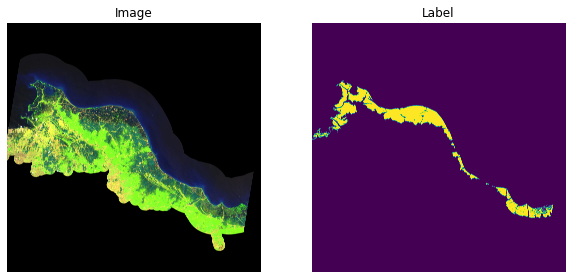

In [216]:
plot_image_and_label(rotated_img, rotated_lbl, band_composite, stretch)

##### Augmentation 2

(1 point)

Run your second chosen augmentation here. If you are using a different function than rotation or flipping, place the function in the next cell, and run it in the cell after that. 

###### Augmentation function (optional) 

In [106]:
### Add your second augmentation function here, if using a different function 
# then those provided here. Otherwise, leave this as is

#@title Image Flipping using "numpy" library

import numpy as np

def flip_image_and_label(image, label, flip_type):
    """
    Applies horizontal or vertical flip augmentation to an image patch and label

    Args:
        image (numpy array) : The input image patch as a numpy array.
        label (numpy array) : The corresponding label as a numpy array.
        flip_type (string) : Based on the direction of flip. Can be either 
            'hflip' or 'vflip'.

    Returns:
        A tuple containing the flipped image patch and label as numpy arrays.
    """
    if flip_type == 'hflip':
        # Apply horizontal flip augmentation to the image patch
        flipped_image = np.flip(image, axis=1)
        
        # Apply horizontal flip augmentation to the label
        flipped_label = np.flip(label, axis=1)
        
    elif flip_type == 'vflip':
        # Apply vertical flip augmentation to the image patch
        flipped_image = np.flip(image, axis=0)
        
        # Apply vertical flip augmentation to the label
        flipped_label = np.flip(label, axis=0)
        
    else:
        raise ValueError("Flip direction must be 'horizontal' or 'vertical'.")
        
    # Return the flipped image patch and label as a tuple
    return flipped_image.copy(), flipped_label.copy()


###### Apply second augmentation 

In [217]:
### fill in augmentation code here
flipped_img, flipped_lbl = flip_image_and_label(image, label, 'hflip')
# flipped_image, flipped_label = flip_image_and_label(image, label, 'vflip')

###### Plot your augmented chip

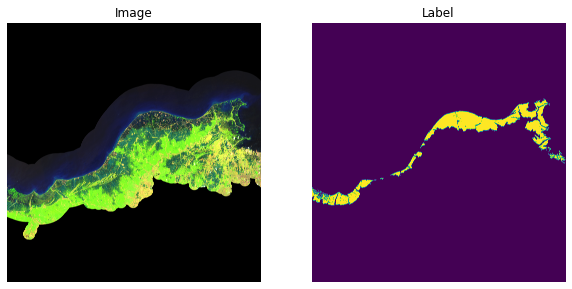

In [218]:
plot_image_and_label(flipped_img, flipped_lbl, band_composite, stretch)

#### Create and demonstrate your loader

(15 points)

##### Create your loader
(10 points)

Adapt the template below to create your custom data loader. 

In [303]:
class ActiveLoadingDataset(Dataset):
    def __init__(self, src_dir, csv_name, usage, patch_size, overlap, 
                 positive_class_threshold = 0.15, apply_normalization=True, 
                 transform=None, **kargs):
        r"""
        src_dir (str or path) : Root of resource directory.
        csv_name (str) : Name of the csv file containing the input paths.
        usage (str) : Either 'train' or 'validation'.
        patch_size (int) : Size of each clipped patches.
        overlap (int) : Amount of overlap (in pixels) between extracted chips.
        positive_class_threshold (float) : A real value as a threshold for the 
            proportion of positive class to the total areal of the chip. Used to 
            decide if the chip should be considered as a positive chip in the 
            sampling process.
        transform (dict) -- Each element is a pair of name of the transformation to
             be used, e.g. ["rotate", "flip"] and its argument
        """
        self.src_dir = src_dir
        self.csv_name = csv_name
        self.overlap = overlap
        self.positive_class_threshold=positive_class_threshold
        self.transform = transform
        
        self.usage = usage
        assert self.usage in ["train", "validate"], "Usage is not recognized."

        self.patch_size = patch_size
        half_size = patch_size // 2

        catalog = pd.read_csv(Path(src_dir) / csv_name)
        self.catalog = catalog[catalog.usage==self.usage]

        self.img_chips = []
        self.lbl_chips = []
        self.coor = []
        
        # Image
        img_path = os.path.join(src_dir, self.catalog[self.catalog.usage==self.usage]['img_dir'].iloc[0])
        with rasterio.open(img_path) as src:
            print(src.profile)
            image = src.read()
            image = min_max_normalize_image_wclip(image, clip_threshold=1)
            image = image_array.transpose(1,2,0)

        # Label
        lbl_path = os.path.join(src_dir, self.catalog[self.catalog.usage==self.usage]['label_dir'].iloc[0])
        with rasterio.open(lbl_path) as src:
            print(src.profile)
            label = src.read(1)

        # Mask
        msk_path = os.path.join(src_dir, self.catalog[self.catalog.usage==self.usage]['mask_dir'].iloc[0])
        with rasterio.open(msk_path) as src:
            print(src.profile)
            mask = src.read(1)

        # Chipping
        crop_ref = [mask, label]
        index = patch_center_index([mask, label], patch_size, overlap, self.usage, positive_class_threshold)

        half_win = patch_size // 2  
        for i in range(len(index)):
            x = index[i][0]
            y = index[i][1]

            self.coor.append([x, y])
            self.img_chips.append(image[x-half_win:x+half_win,   
                              y-half_win:y+half_win, :]) 
            self.lbl_chips.append(label[x-half_win:x+half_win,   
                              y-half_win:y+half_win])
            
        msg = '--------------{} patches cropped--------------'
        print(msg.format(len(self.img_chips)))
        

    def __getitem__(self, index):

        image_chip = self.img_chips[index]
        label_chip = self.lbl_chips[index]

        if self.usage == "train" and transform:

            # revise lines 84-88 to add your augmentation of choice
            # if applying flipping, make sure that the flip direction is 
            # randomly chosen also, which can be achieved using random choice 
            # from a list of the two directions.  
            if (random.random() > 0.5) and 'rotate' in transform.keys():
              image_chip, label_chip = rotate_image_and_label(image_chip, label_chip, transform['rotate'])

            if 'flip' in transform.keys():
              if random.randint(0, 1)==0:
                direction = 'hflip'
              else:
                direction = 'vflip'
              image_chip, label_chip = flip_image_and_label(image_chip, label_chip, direction)

        # Convert numpy arrays to torch tensors.
        # Image chips should be: CHW if not transpose to correct order of 
        # dimensions.
        image_tensor = torch.from_numpy(image_chip.transpose((2, 0, 1))).float()
        label_tensor = torch.from_numpy(np.ascontiguousarray(label_chip)).long()

        return image_tensor, label_tensor

    def __len__(self):
        return len(coor)

##### Demonstrate your loader
(5 points) 

Use/adapt the following arguments to run code. 

In [269]:
src_dir = "/content/gdrive/MyDrive/sam/GEOG315/assignment3_data/"
csv_name = "pond_scenes_train_val.csv"
usage = "train"
patch_size = 256
overlap = 25
positive_class_threshold = 0.15
apply_normalization = True
transform = {
    "rotate": (-10, 10),
    "flip": None,
}

###### Training dataset

In [304]:
train_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap, 
    positive_class_threshold, apply_normalization, transform
)
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 3, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}
{'driver': 'RST', 'dtype': 'float32', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}
{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}
Number of patches: 54
Patched from:
[[1158, 334], [1158, 540], [952, 746], [1158, 746], [1364, 746], [952, 952], [1158, 952], [1364, 952], [334, 1158], [540, 1158], [746, 1158], [952, 1158], [1158, 1158], [1364, 1158], [1570, 1158], [540, 1364], [746, 1364], [952, 1364], [1158, 1364], [1364, 1364], [540, 1570]

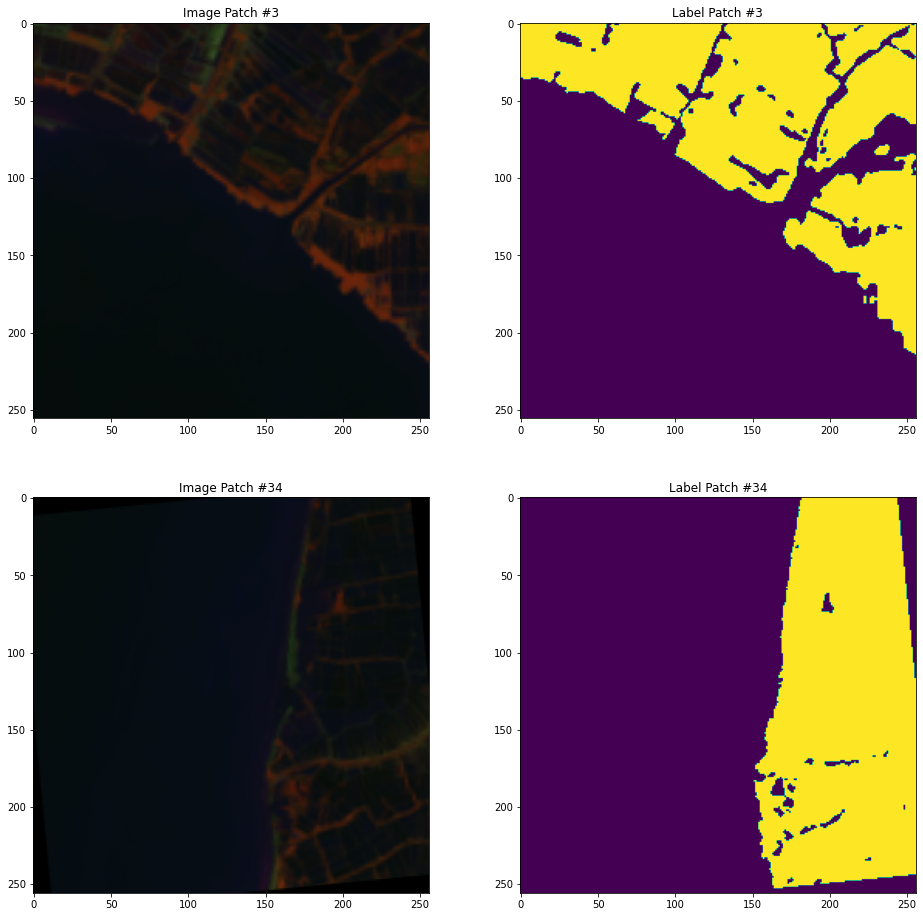

In [227]:
show_random_patches(train_dataset, sample_num=2, rgb_bands=(0, 1, 2))

###### Validation dataset

In [270]:
src_dir = "/content/gdrive/MyDrive/sam/GEOG315/assignment3_data/"
csv_name = "pond_scenes_train_val.csv"
usage = "train"
patch_size = 256
overlap = 25
positive_class_threshold = 0.15
apply_normalization = True
transform = {
    "rotate": (-10, 10),
    "flip": None,
}

In [305]:
validation_dataset = ActiveLoadingDataset(
    src_dir, csv_name, usage, patch_size, overlap, 
    positive_class_threshold, apply_normalization, transform
)
validation_loader = DataLoader(validation_dataset, batch_size = 4, shuffle = False)

{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 3, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}
{'driver': 'RST', 'dtype': 'float32', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}
{'driver': 'RST', 'dtype': 'uint8', 'nodata': None, 'width': 3975, 'height': 4049, 'count': 1, 'crs': CRS.from_epsg(32649), 'transform': Affine(15.0, 0.0, 172762.5,
       0.0, -15.0, -684622.5), 'blockysize': 1, 'tiled': False}
Number of patches: 54
Patched from:
[[1158, 334], [1158, 540], [952, 746], [1158, 746], [1364, 746], [952, 952], [1158, 952], [1364, 952], [334, 1158], [540, 1158], [746, 1158], [952, 1158], [1158, 1158], [1364, 1158], [1570, 1158], [540, 1364], [746, 1364], [952, 1364], [1158, 1364], [1364, 1364], [540, 1570]

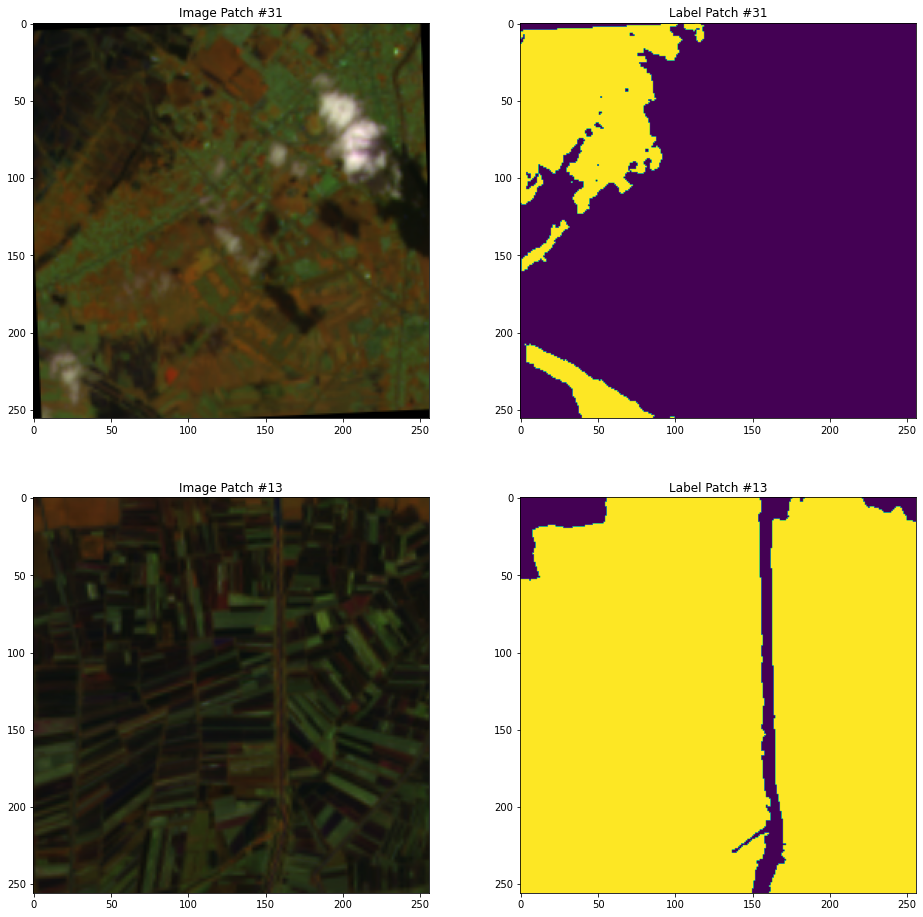

In [308]:
show_random_patches(validation_dataset, sample_num=2, rgb_bands=(0, 1, 2))